In [1]:
import math
import numpy as np
from pydub import AudioSegment
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit,QuantumRegister, assemble, Aer
from qiskit.visualization import plot_histogram
from qiskit.compiler import transpile

/Users/ameyrodge/anaconda3/lib/python3.11/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Text(0, 0.5, 'amplitude')

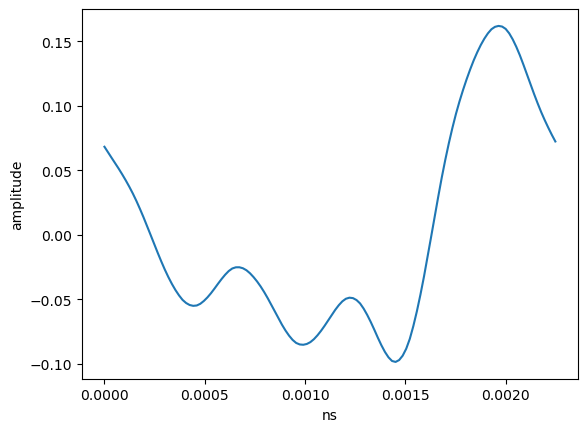

In [2]:
n_qubits = 7
import soundfile as sf
import sounddevice as sd
Piano,fsp = sf.read('Audio_samples/PianoLaPeriod.wav')
timeP = np.arange(len(Piano))/fsp
plt.plot(timeP,Piano)
plt.xlabel('ns')
plt.ylabel('amplitude')

In [3]:
samples=Piano

/Users/ameyrodge/anaconda3/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


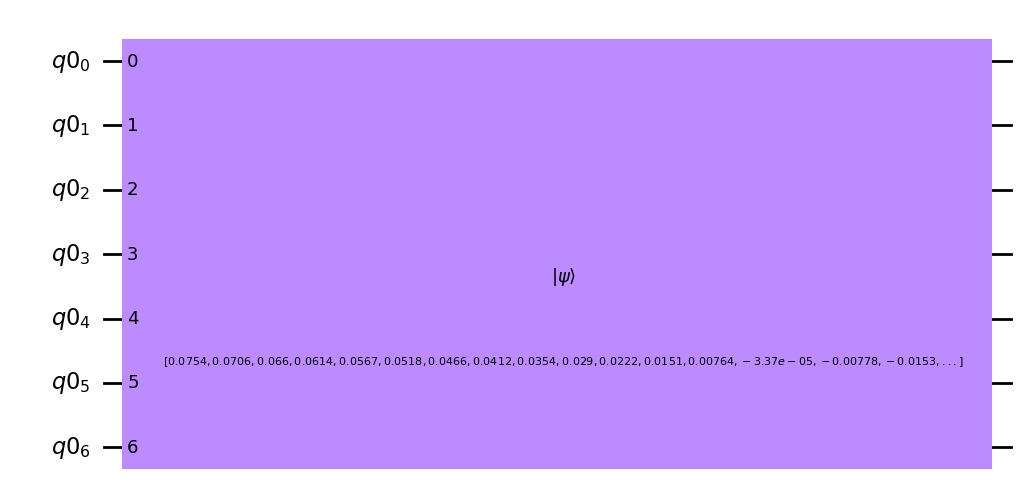

In [4]:
#Encoding a normalized set of amplitudes from the audio samples onto the states of the qubits
def create_encoded_qc(samples, n_qubits):
    q = QuantumRegister(n_qubits)
    qc = QuantumCircuit(q)
    
    normalized_amplitudes = samples / np.linalg.norm(samples)
    qc.initialize(normalized_amplitudes, [q[i] for i in range(n_qubits)])
    return qc 

# Creating quantum circuit
audio_qc = create_encoded_qc(samples, n_qubits)
audio_qc.draw('mpl')

## Creating a function QFT and applying it to qunatum state

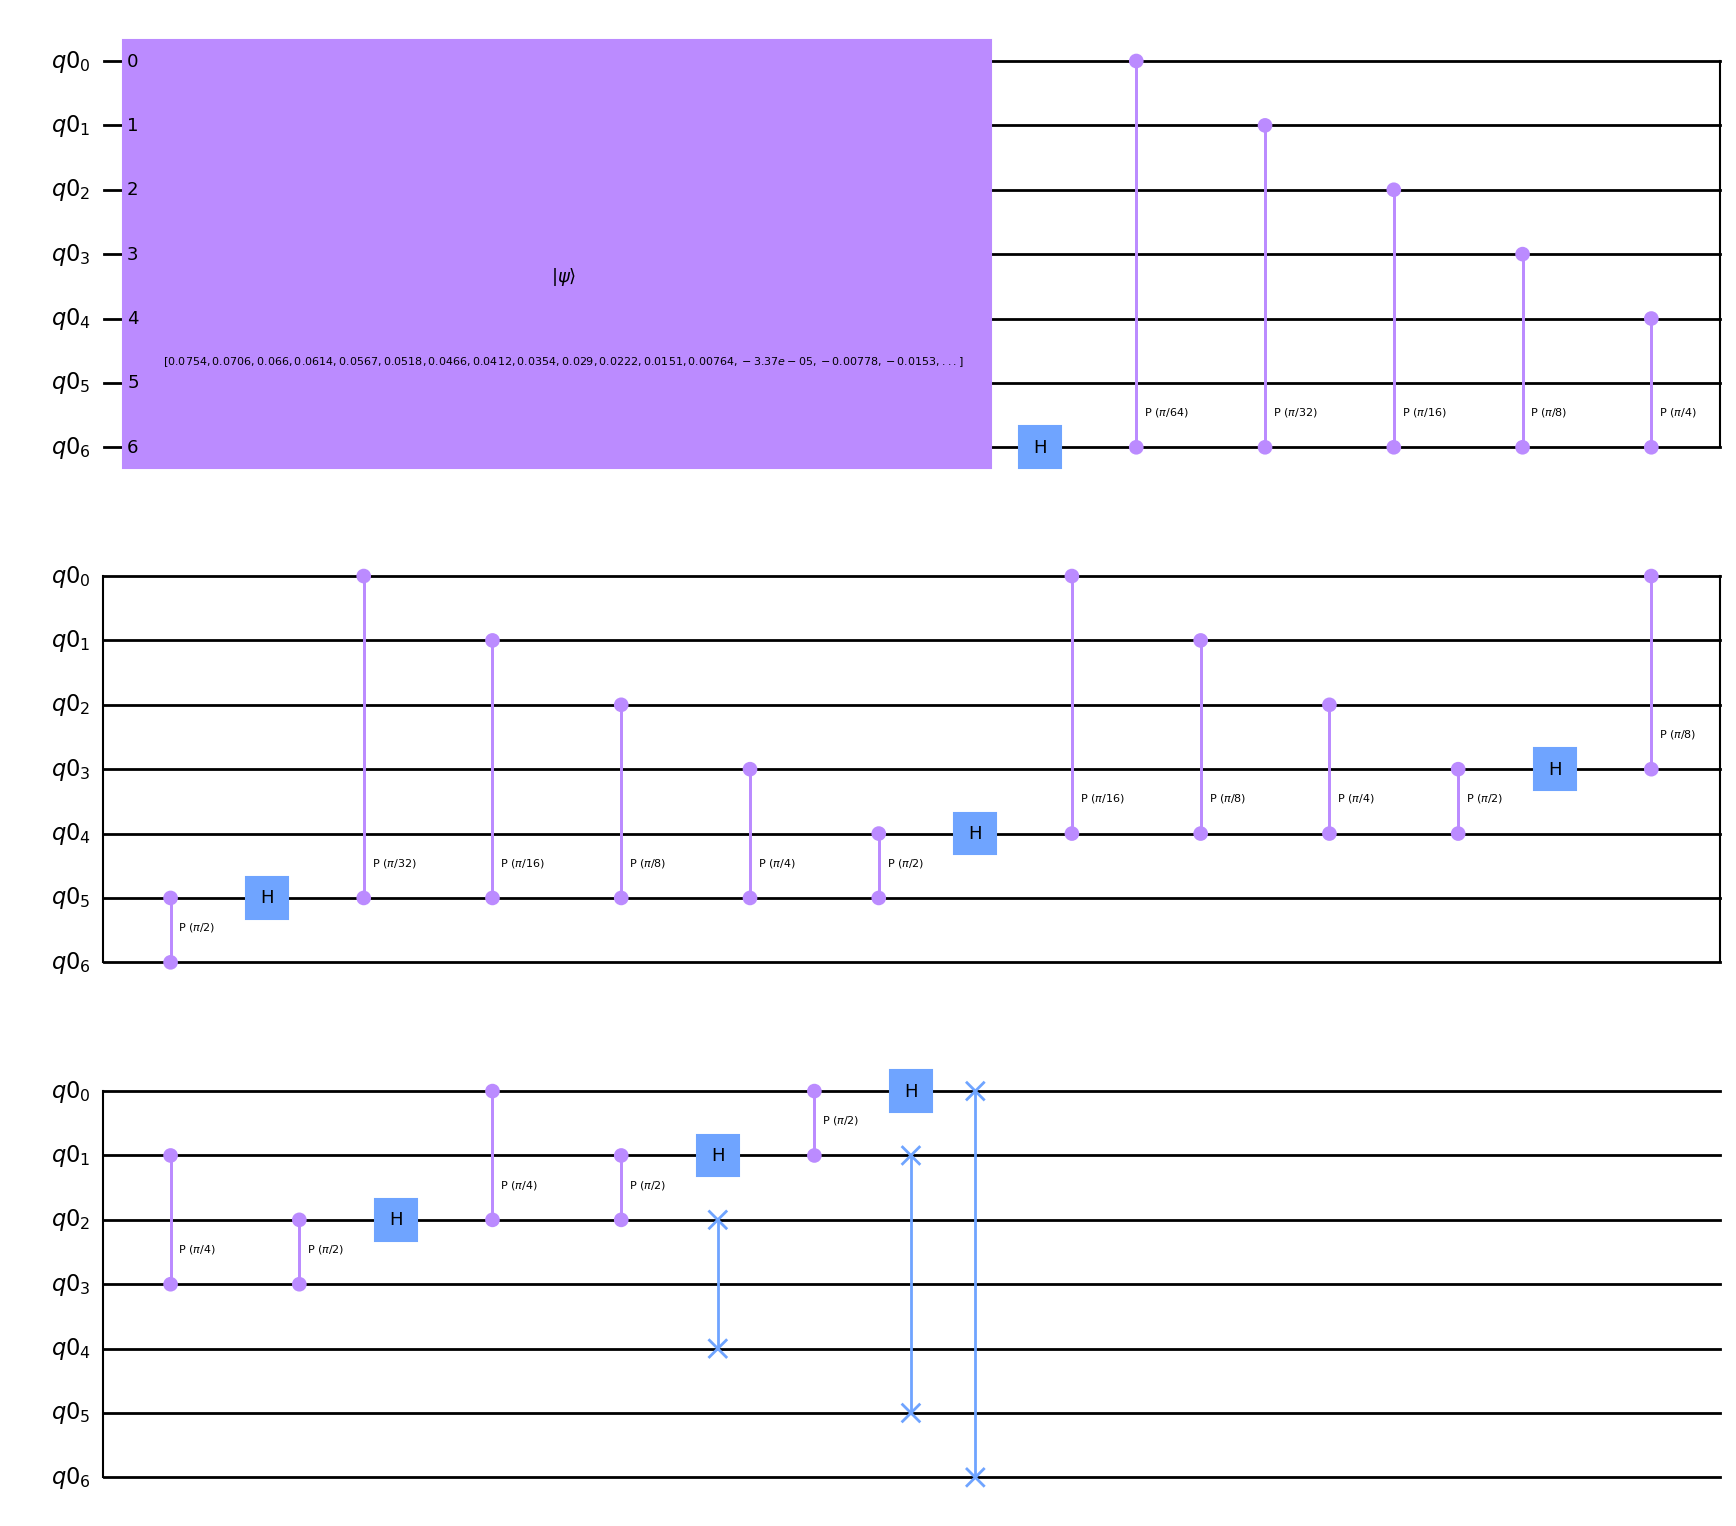

In [5]:
def qft_rotations(circuit, n):
    # This function implements the first part of the Quantum Fourier Transform (QFT), which applies Hadamard gates and controlled-phase gates to the first n qubits in the quantum circuit.

    if n == 0:
        # If n is 0, the function returns the circuit unchanged.
        return circuit

    n -= 1
    # Subtracts 1 from n to prepare for the next iteration of the function.

    circuit.h(n)
    # Applies a Hadamard gate to the nth qubit, preparing it for the next stage of the QFT.

    for qubit in range(n):
        # Applies a controlled-phase gate to the qubit and the nth qubit, with an angle of pi/2^(n-qubit).
        circuit.cp(np.pi/2**(n-qubit), qubit, n)

    qft_rotations(circuit, n)
    # Recursively calls the function again to apply the same operations to the remaining qubits.

def swap_registers(circuit, n):
    # This function implements the second part of the QFT, which swaps the qubits in the circuit to arrange them in the correct order for the output of the QFT.

    for qubit in range(n//2):
        # Swaps the qubit and the qubit n-qubit-1, effectively reversing the order of the qubits.
        circuit.swap(qubit, n-qubit-1)

    return circuit

def qft(circuit, n):
    # This function combines the first two functions to implement the complete Quantum Fourier Transform (QFT) on the first n qubits in the quantum circuit.

    """QFT on the first n qubits in circuit"""

    qft_rotations(circuit, n)
    # Applies the first part of the QFT to the qubits.

    swap_registers(circuit, n)
    # Applies the second part of the QFT to the qubits.

    return circuit

circuit = audio_qc
qft(circuit, n_qubits)
audio_qc.draw('mpl')
# Draws the circuit to visualize the quantum gates and their connections.


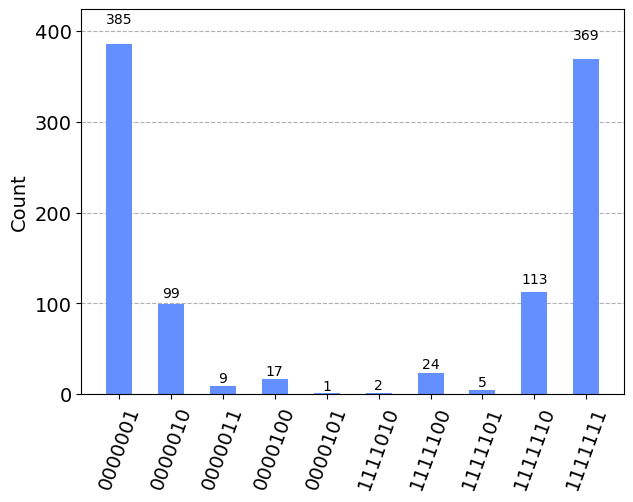

In [6]:
## Measuring all qubits
audio_qc.measure_all()

# Transpile the circuit to a low-level representation for efficient execution
backend = Aer.get_backend("aer_simulator")
transpiled_qc = transpile(audio_qc, backend)

# Simulate the circuit on the simulator and obtain the measurement outcomes
counts = backend.run(transpiled_qc).result().get_counts()

# Define a function to extract the QFT output from the measurement outcomes
def get_qft_counts(counts, n_qubits):
    # Convert each binary string in the counts dictionary to an integer
    return [int(k, 2) for k in counts.keys()]

# Extract the QFT counts from the measurement outcomes
qft_counts = get_qft_counts(counts, n_qubits)[:len(samples)]

# Plot the distribution of the QFT counts
plot_histogram(counts)


In [7]:
# decoding the results
top_indices = np.argsort(-np.array(qft_counts[:3]))
freqs = top_indices*fsp/2**n_qubits
freqs

array([441.328125, 882.65625 ,   0.      ])